# 决策树

### 步骤
- 1.计算不纯度
- 2.选取不纯度最高的特征进行分支
- 3.计算不纯度
- 4.继续划分

In [46]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# 导入自己写的工具类
from my_tools import *
# 忽略warning
import warnings
warnings.filterwarnings("ignore")

### 加载数据

In [2]:
jibing_res = pd.read_excel("./jibing_feature_res_final.xlsx")
jibing = pd.read_excel("./jibing_feature_final.xlsx")

In [3]:
jibing.head()

,左右,是否外伤,症状持续时间,明显夜间痛,年龄,高血压,高血脂,2型糖尿病,吸烟与否,饮酒与否,...,腺苷脱氨酶ADA,果糖胺,肌酸激酶,α-L-盐藻糖苷酶,乳酸,淀粉酶,同型半胱氨酸,铁,总铁结合力,血型
0,0,0,3,0,65,1,0,0,0,0,...,10.0,1.32,48.0,12.0,1.9,49.0,9.9,12.3,43.5,3
1,1,1,2,0,62,1,0,0,0,0,...,10.0,1.67,77.0,16.0,1.4,81.0,9.2,16.9,55.5,0
2,1,0,4,1,55,0,0,0,0,0,...,15.0,1.86,78.0,22.0,1.9,89.0,9.9,7.0,51.4,0
3,1,0,3,0,60,0,0,0,0,0,...,16.0,1.68,92.0,12.0,1.4,69.0,9.3,15.8,53.0,0
4,0,1,3,0,61,0,0,0,0,0,...,13.0,1.60,58.0,14.0,1.7,153.0,8.1,13.2,45.9,0


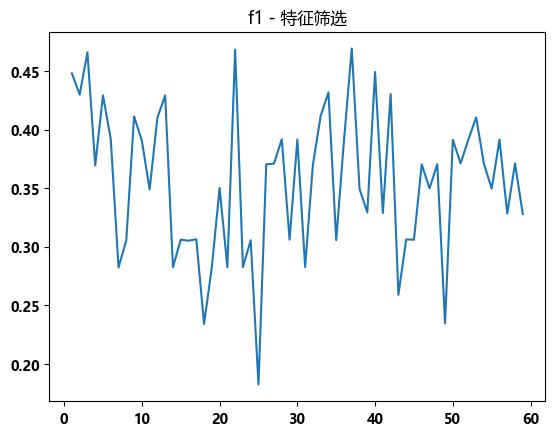

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
f1_list = []
best_k = -1
best_score = -1
set_font()
for i in range(1,60):
#     sampler = RandomOverSampler(sampling_strategy=0.2, random_state=42)
    smote = SMOTE(sampling_strategy=1, random_state=42)
    selector = SelectKBest(mutual_info_classif, k=i)
    jibing_ = selector.fit_transform(jibing, jibing_res)
    Xtrain,Xtest,Ytrain,Ytest = train_test_split(jibing_,jibing_res,test_size=0.3,random_state=42)
#     Xtrain, Ytrain = sampler.fit_resample(Xtrain,Ytrain)
    Xtrain, Ytrain = smote.fit_resample(Xtrain,Ytrain)
    clf = tree.DecisionTreeClassifier(random_state=42)
    clf.fit(Xtrain, Ytrain)
    y_pre = clf.predict(Xtest)
    metrics_ = res_metrics(Ytest,y_pre,"调参")
    f1_list.append(metrics_["f1-score"])
    if best_score < metrics_["f1-score"]:
        best_k = i
        best_score = metrics_["f1-score"]
zhexiantu(range(1,60),f1_list,"f1 - 特征筛选")

### 分箱+均衡化
- 使用一种自定义的网格搜索方法

In [6]:
best_method = "s"
best_num = -1
best_score = 0
for method in ["uniform","quantile","kmeans"]:
    for num in np.linspace(3,100,10,dtype = int):
        jibing_res = pd.read_excel("./jibing_feature_res_final.xlsx")
        jibing = pd.read_excel("./jibing_feature_final.xlsx")
        col = jibing.columns.tolist()
        col = col[10:59]
        col.append("年龄")
        est = KBinsDiscretizer(n_bins=num, encode='ordinal', strategy=method)
        est.fit(jibing[col])
        jibing[col] = est.transform(jibing[col])
        
        sampler = SMOTE(sampling_strategy=1, random_state=42)
#         sampler = RandomOverSampler(sampling_strategy=1, random_state=42)
        Xtrain,Xtest,Ytrain,Ytest = train_test_split(jibing,jibing_res,test_size=0.3,random_state=42)
        Xtrain, Ytrain = sampler.fit_resample(Xtrain,Ytrain)
        
        clf = tree.DecisionTreeClassifier(random_state=42)
        clf.fit(Xtrain,Ytrain)
        y_pre = clf.predict(Xtest)
        
        metrics_ = res_metrics(Ytest,y_pre,"调参")
        if metrics_["f1-score"] > best_score:
            best_num = num
            best_method = method
            best_score = metrics_["f1-score"]

### 最佳的分箱方法是quantile，最佳的分箱数目为89

In [7]:
print("best_score={}\nbest_num={}\nbest_method={}".format(best_score,best_num,best_method))

best_score=0.48395599537538303
best_num=89
best_method=quantile


### 连续型数据分箱后的结果

In [10]:
jibing.head()

,左右,是否外伤,症状持续时间,明显夜间痛,年龄,高血压,高血脂,2型糖尿病,吸烟与否,饮酒与否,...,腺苷脱氨酶ADA,果糖胺,肌酸激酶,α-L-盐藻糖苷酶,乳酸,淀粉酶,同型半胱氨酸,铁,总铁结合力,血型
0,0,0,3,0,25.0,1,0,0,0,0,...,6.0,1.0,6.0,4.0,15.0,16.0,29.0,16.0,9.0,3
1,1,1,2,0,22.0,1,0,0,0,0,...,6.0,21.0,32.0,8.0,9.0,49.0,21.0,42.0,48.0,0
2,1,0,4,1,15.0,0,0,0,0,0,...,11.0,40.0,33.0,17.0,15.0,56.0,29.0,1.0,32.0,0
3,1,0,3,0,20.0,0,0,0,0,0,...,12.0,22.0,46.0,4.0,9.0,39.0,22.0,35.0,38.0,0
4,0,1,3,0,21.0,0,0,0,0,0,...,9.0,16.0,13.0,6.0,13.0,68.0,10.0,20.0,14.0,0


In [12]:
jibing_res = pd.read_excel("./jibing_feature_res_final.xlsx")
jibing = pd.read_excel("./jibing_feature_final.xlsx")
col = jibing.columns.tolist()
col = col[10:59]
col.append("年龄")
est = KBinsDiscretizer(n_bins=89, encode='ordinal', strategy="quantile")
est.fit(jibing[col])
jibing[col] = est.transform(jibing[col])

In [13]:
sampler = SMOTE(sampling_strategy=1, random_state=42)
Xtrain,Xtest,Ytrain,Ytest = train_test_split(jibing,jibing_res,test_size=0.3,random_state=42)
Xtrain, Ytrain = sampler.fit_resample(Xtrain,Ytrain)

clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(Xtrain,Ytrain)
y_pre = clf.predict(Xtest)

metrics_ = res_metrics(Ytest,y_pre,"分箱后f1")

######################分箱后f1#######################
+--------------------+--------------------+---------------------+
|     precision      |       recall       |          f1         |
+--------------------+--------------------+---------------------+
| 0.8112885044964844 | 0.3448275862068966 | 0.48395599537538303 |
+--------------------+--------------------+---------------------+


## 特征选择

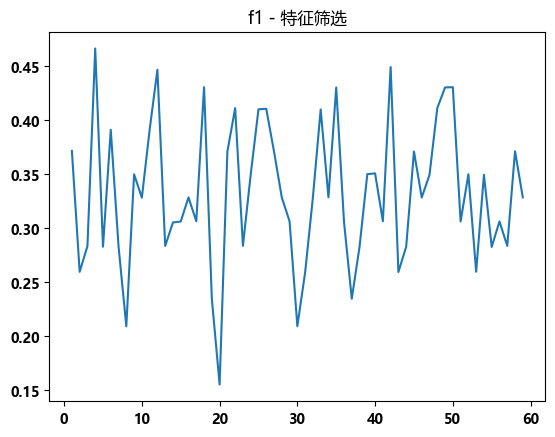

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
f1_list = []
best_k = -1
best_score = -1
set_font()
for i in range(1,60):
#     sampler = RandomOverSampler(sampling_strategy=0.2, random_state=42)
    smote = SMOTE(sampling_strategy=1, random_state=42)
    selector = SelectKBest(mutual_info_classif, k=i)
    jibing_ = selector.fit_transform(jibing, jibing_res)
    Xtrain,Xtest,Ytrain,Ytest = train_test_split(jibing_,jibing_res,test_size=0.3,random_state=42)
#     Xtrain, Ytrain = sampler.fit_resample(Xtrain,Ytrain)
    Xtrain, Ytrain = smote.fit_resample(Xtrain,Ytrain)
    clf = tree.DecisionTreeClassifier(random_state=42)
    clf.fit(Xtrain, Ytrain)
    y_pre = clf.predict(Xtest)
    metrics_ = res_metrics(Ytest,y_pre,"调参")
    f1_list.append(metrics_["f1-score"])
    if best_score < metrics_["f1-score"]:
        best_k = i
        best_score = metrics_["f1-score"]
zhexiantu(range(1,60),f1_list,"f1 - 特征筛选")

In [37]:
best_k

4

In [38]:
best_score

0.4663635365767202

In [43]:
smote = SMOTE(sampling_strategy=1, random_state=42)
selector = SelectKBest(mutual_info_classif, k=4)
jibing_ = selector.fit_transform(jibing, jibing_res)
Xtrain,Xtest,Ytrain,Ytest = train_test_split(jibing_,jibing_res,test_size=0.3,random_state=42)

#     Xtrain, Ytrain = sampler.fit_resample(Xtrain,Ytrain)
Xtrain, Ytrain = smote.fit_resample(Xtrain,Ytrain)
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(Xtrain, Ytrain)

y_pre = clf.predict(Xtest)
metrics_ = res_metrics(Ytest,y_pre,"best_k - f1")

###################best_k - f1####################
+--------------------+--------------------+---------------------+
|     precision      |       recall       |          f1         |
+--------------------+--------------------+---------------------+
| 0.8060573452934983 | 0.3275862068965517 | 0.46584884247907565 |
+--------------------+--------------------+---------------------+


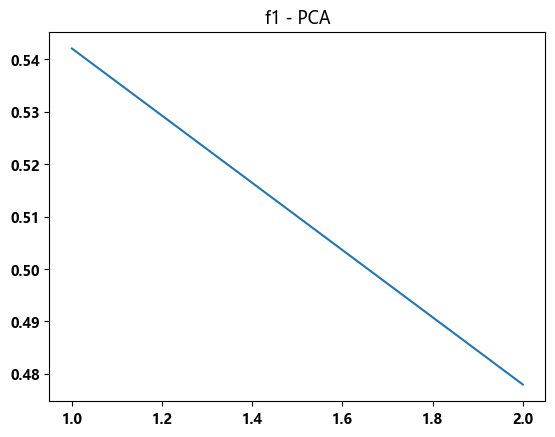

In [48]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
f1_list = []
for i in range(1,3):
    clf = tree.DecisionTreeClassifier(random_state=42)
    pca = PCA(n_components=i,random_state=42)
    Xtrain_ = pca.fit_transform(Xtrain,Ytrain)
    clf.fit(Xtrain_, Ytrain)
    Xtest_ = pca.fit_transform(Xtest)
    y_pre = clf.predict(Xtest_)
    metrics_ = res_metrics(Ytest,y_pre,"调参")
    f1_list.append(metrics_["f1-score"])
zhexiantu(range(1,3),f1_list,"f1 - PCA")

In [52]:
f1_list = []
for i in range(1,4):
    clf = tree.DecisionTreeClassifier(random_state=42)
    tsne = TSNE(n_components=i,random_state=42)
    Xtrain_ = tsne.fit_transform(Xtrain,Ytrain)
    clf.fit(Xtrain_, Ytrain)
    Xtest_ = tsne.fit_transform(Xtest)
    y_pre = clf.predict(Xtest_)
    metrics_ = res_metrics(Ytest,y_pre,"调参")
    f1_list.append(metrics_["f1-score"])

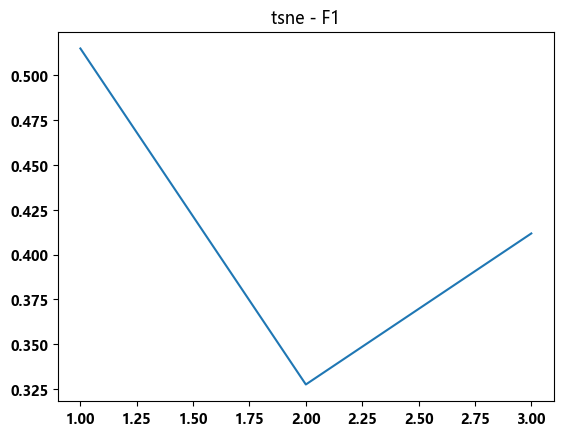

In [54]:
zhexiantu(range(1,4),f1_list,"tsne - F1")

### 结果为0.51 还需要继续调参

In [55]:
clf = tree.DecisionTreeClassifier(random_state=42)
tsne = TSNE(n_components=1,random_state=42)
Xtrain_ = tsne.fit_transform(Xtrain,Ytrain)
clf.fit(Xtrain_, Ytrain)
Xtest_ = tsne.fit_transform(Xtest)
y_pre = clf.predict(Xtest_)
metrics_ = res_metrics(Ytest,y_pre,"TSNE-f1")

#####################TSNE-f1######################
+-------------------+--------------------+--------------------+
|     precision     |       recall       |         f1         |
+-------------------+--------------------+--------------------+
| 0.802205521848379 | 0.3793103448275862 | 0.5150753564926158 |
+-------------------+--------------------+--------------------+


## 调参与剪枝

### criterion
用于不纯度的计算，不纯度越低，对训练集的拟合越好。

entropy信息熵：对不纯度的乘法更强，决策树的生长更加精确但容易过拟合，出现欠拟合现象时使用。

gini基尼系数：计算速度较快，通常使用基尼系数。

### splitter

用于控制随机性。

best：选择更重要的分支进行分支。

random：分支更加随机，树的深度会更深，可以防止过拟合。

### min_samples_leaf
最小叶子节点，分支后叶子节点小于这个值就不会再分


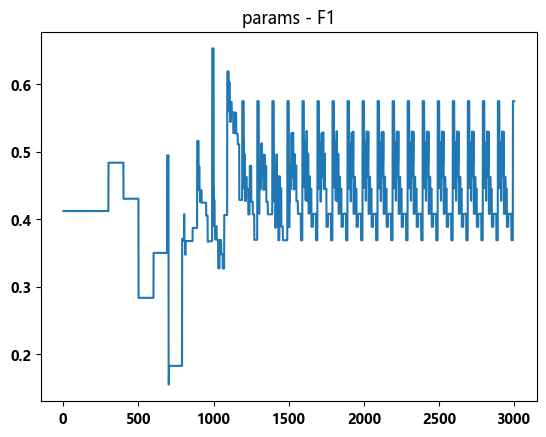

In [81]:
# 搜索最佳参数
f1_list = []
best_f1 = -1.1
best_max_d = -1
best_min_sl = -1
best_min_ss = -1
for max_d in np.linspace(1,30,30,dtype=int):
    for min_sl in np.linspace(1,20,10,dtype=int):
        for min_ss in np.linspace(2,20,10,dtype=int):
            clf = DecisionTreeClassifier(max_depth=max_d,min_samples_leaf=min_sl,min_samples_split=min_ss)
            clf.fit(Xtrain_, Ytrain)
            y_pre = clf.predict(Xtest_)
            metrics_ = res_metrics(Ytest,y_pre,"调参")
            if best_f1 < metrics_["f1-score"]:
                best_max_d = max_d
                best_min_sl = min_sl
                best_min_ss = min_ss
                best_f1 = metrics_["f1-score"]
            f1_list.append(metrics_["f1-score"])
zhexiantu(np.linspace(1,3000,3000),f1_list,"params - F1")

### 出现上面这种趋势的原因：树的最大深度达到一定限制之后
### 再加大最大深度没有意义，变成f1随着其他两个属性呈周期性变化。

In [82]:
print("best_f1:{}\nmax_depth:{}\nmin_samples_leaf:{}\nmin_samples_split:{}".format(best_f1,best_max_d,best_min_sl,best_min_ss))

best_f1:0.6529176934256228
max_depth:10
min_samples_leaf:20
min_samples_split:2


### 结果提升了很多
### f1-score 为0.65

In [85]:
clf = DecisionTreeClassifier(max_depth=10,min_samples_leaf=20,min_samples_split=2)
clf.fit(Xtrain_, Ytrain)
y_pre = clf.predict(Xtest_)
metrics_ = res_metrics(Ytest,y_pre,"DT-final")

#####################DT-final#####################
+-------------------+--------------------+--------------------+
|     precision     |       recall       |         f1         |
+-------------------+--------------------+--------------------+
| 0.799569364630173 | 0.5517241379310345 | 0.6529176934256228 |
+-------------------+--------------------+--------------------+


### 可视化

In [84]:
import graphviz
dot_data = tree.export_graphviz(clf,
                                filled=True,#填充颜色
                                rounded=True,#框的形状
                                out_file="./tree.dot",#用于生成决策树图片的文件
                                fontname="Microsoft YaHei"#设置字体，否则会乱码
)
graph = graphviz.Source(dot_data)

### 最终的决策树

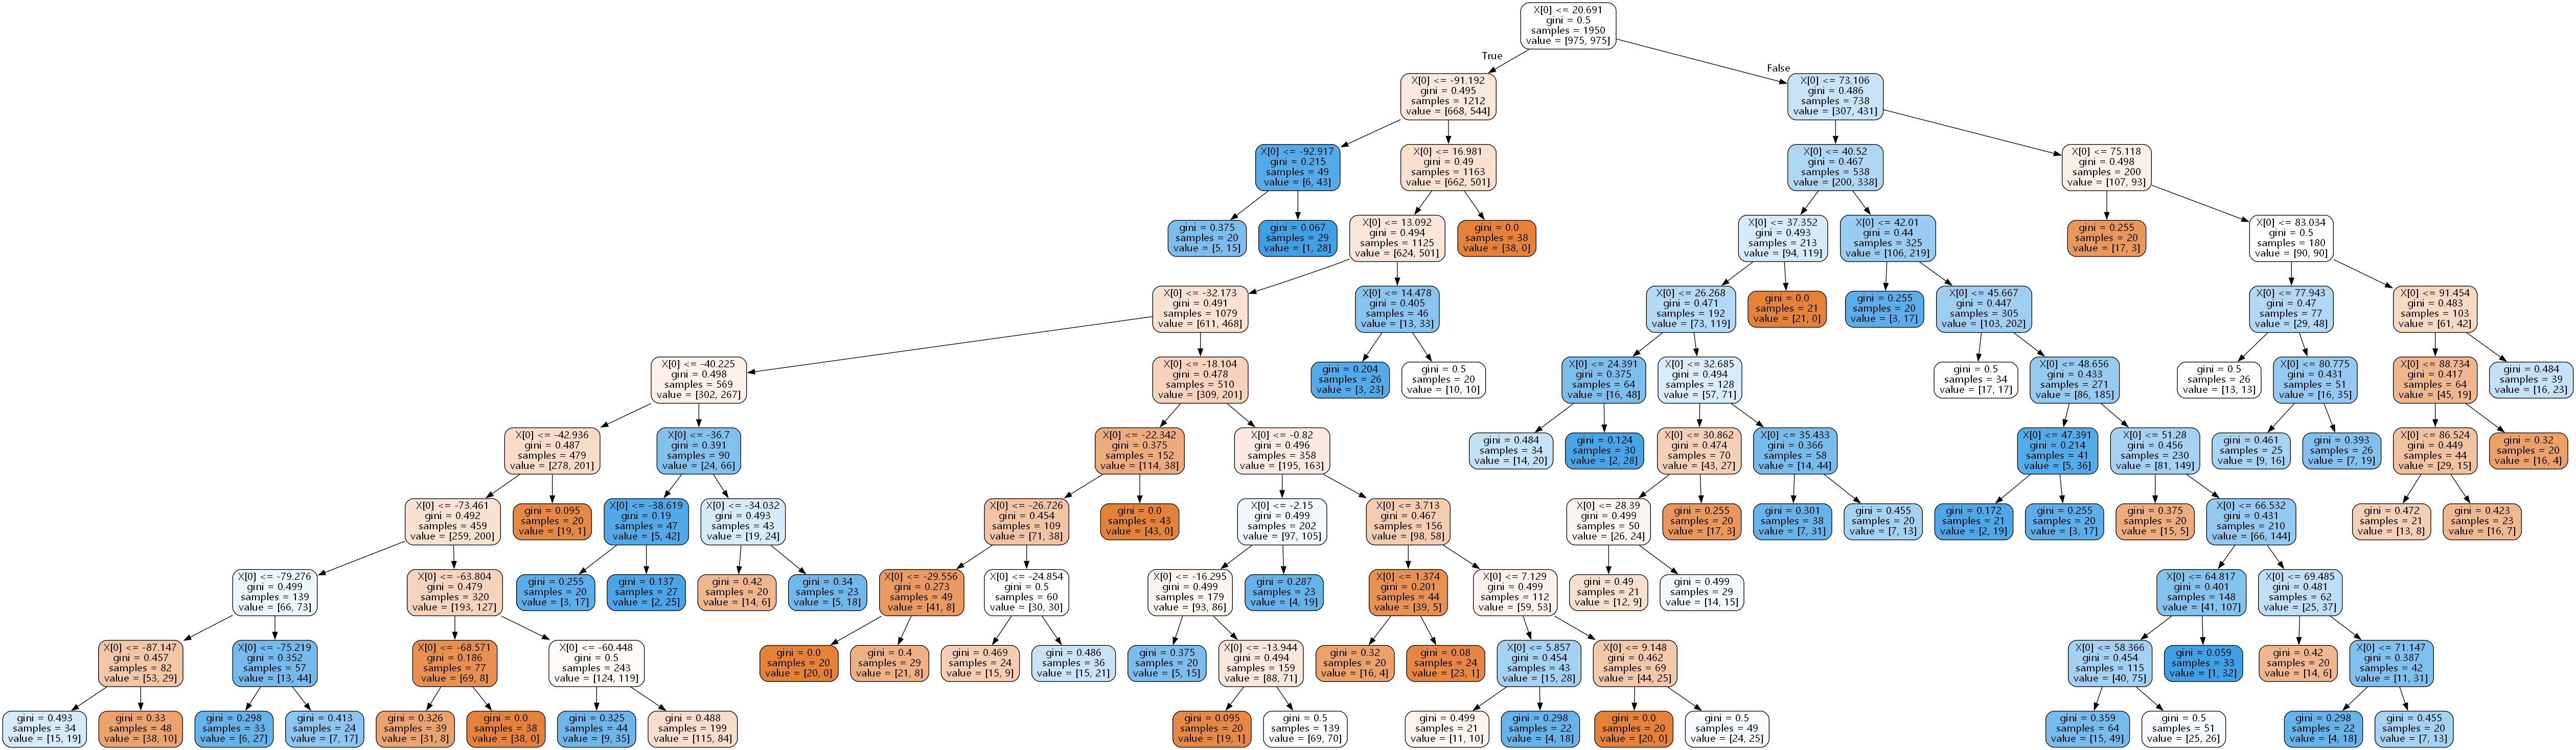